# Local Binary Patterns
- Texture descriptor
- Unlike Haralick that computes **global** representation of texture basaed GLCM, LBP computes **local** repr. pf texture, by comparing each pixel with its surrounding neighborhood of pixel values.
- Used to perform robust face recognition. 

## How it works
- Refer [paper](http://www.outex.oulu.fi/publications/pami_02_opm.pdf)
- For each pixel in grayscale image, we select neighborhood size of r surrounding center pixel and an LBP value is calc for this pixel and stored in output 2D array of same h/w as image.
![Circular symmetric neighborhood](../images/embedded_images/lbp_circle.png)
- We start derivation of our gray scale and rotation invariant texture operator by defining texture $T$ in a local neighborhood of a monochrome texture image as the joint distribution of gray levels of $P(P>1)$ image pixels:
$$T=t(g_c, g_0, g_1,..., g_{p-1})$$
- As a step towards grayscale invariance, we subtract the gray value of center pixel $(g_{c})$ from gray values of circularly symmetric neighborhood $g_{p} (p=0,1,...P-1)$ giving:
$$T=t(g_c, g_0-gc, g_1-g_c,..., g_{p-1}-g_c)$$
- After factorization and appx:
$$T=t(g_0-gc, g_1-g_c,..., g_{p-1}-g_c)$$
- Signed differences $g_p-g_c$ are not affected by change in mean luminance.  We achieve invariance w.r.t scaling of gray scale by considering just signs of differences instead of exact values.:
$$T=t(s(g_0-gc), s(g_1-g_c),..., s(g_{p-1}-g_c))$$
where
$$
s(x) = 
\begin{cases}
1&\text{$x\ge 0$}\\
0&\text{$x \lt 0$}\\
\end{cases}
$$
- By assigning binomial factor $2^p$ for each $s(g_p-g_0)$, we get unique $LBP_{P,R}$ for the  number that characterizes the spatial structure of local image texture:
$$
LBP_{P,R} = \sum_{p=0}^{p-1}s(g_p-g_0)2^p
$$   
- The above equation has rotation redundancy since a circular neighbor can have  pixel combinations which are repeated by different rotations.
- We achieve and improve rotation invariance($ri$) by using uniform patterns and finer quantization of angular space.
- The uniformity measure($u2$) corresponds to number of spatial transitions (bitwise 0/1 changes) in the 'pattern'. We designate patterns that have U value of atmost 2 as uniform and we get:
$$
LBP_{P,R}^{riu2} =  
\begin{cases}
\sum_{p=0}^{p-1}s(g_p-s_c)&\text {if $U(LBP_{P,R}) \le 2$}\\
P+1&\text{otherwise}\\
\end{cases}
$$
- Exactly $P+1$ uniform binary patterns are grouped individually in 0 to P labels. The rest of non-uniform binary patterns are all labelled as a single $(P+1)$ label. 
- The non uniform binary patterns are all grouped in single label because it makes a small portion of uniform patterns
- Therefore, the mapping from $LBP_{P,R}$ to $LBP_{P,R}^{riu2}$ has $P+2$ distinct output values.
-
- The final texture feature employed in texture analysis is the histogram of the operator output accumulated over a texture sample. 

In [1]:
import sys
sys.path.append("../")

In [2]:
from skimage import feature
import numpy as np
from imutils import paths
import cv2
from cv_imshow import display_image, create_subplot
from matplotlib import pyplot as plt

In [3]:
class LocalBinaryPatterns:
    def __init__(self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius
    
    def describe(self, image, eps=1e-7):
        #compute local binary pattern and then use LBP to build histo patters
        lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=range(0,self.numPoints+3), 
                                range=(0,self.numPoints+2))
        
        hist = hist.astype("float")
        hist /= (hist.sum()+eps)
        
        return hist

In [4]:
args = {
    "dataset":"../images/lbp/shirts/",
    "query": "../images/lbp/query/query_02.jpg"
}

In [5]:
#init lbp descriptor and init the index dict where the image filename is key 
#and feature vector is value
desc = LocalBinaryPatterns(24,8)
index = {}

#loop over shirt images 
for imagePath in paths.list_images(args["dataset"]):
    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    hist = desc.describe(gray)
    
    filename = imagePath[imagePath.rfind("/")+1:]
    index[filename] = hist

#1. shirt_10.jpg: 0.0117
#2. shirt_09.jpg: 0.0161
#3. shirt_02.jpg: 0.0175


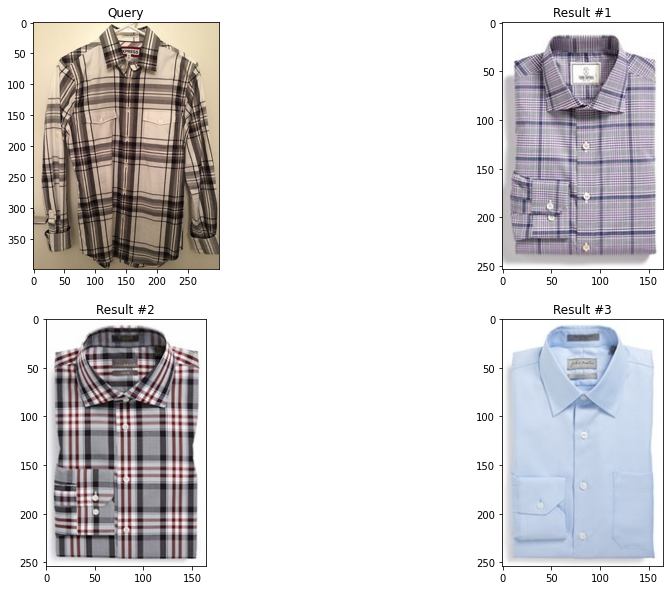

In [6]:
query = cv2.imread(args["query"])
queryFeatures = desc.describe(cv2.cvtColor(query, cv2.COLOR_BGR2GRAY))

fig = plt.figure(figsize=(15,10))
rows = 2 
columns = 2
create_subplot(fig, rows, columns, 1, "Query", query)
results = {}

for (k, features) in index.items():
    #compute chi-squared dist between current features and query features
    d = 0.5*np.sum(((features-queryFeatures)**2)/(features+queryFeatures+ 1e-10))
    results[k] = d

results = sorted([(v,k) for (k,v) in results.items()])[:3]

#loop over results
for (i,(score, filename)) in enumerate(results):
    print("#%d. %s: %.4f"%(i+1, filename, score))
    image = cv2.imread(args["dataset"] + "/" + filename)
    create_subplot(fig, rows, columns, i+2,"Result #{}".format(i+1), image)